In [1]:
using Distributions
using StaticArrays
using StatsPlots
default(fmt=:png, titlefontsize=10)

safemul(x, y) = x == 0 ? x : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end


confint_or_wald (generic function with 1 method)

In [3]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? oftype(ω, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function pvalue_or_pearson_chisq_firth(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a+0.5, b+0.5, c+0.5, d+0.5; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [4]:
function _gstat_or(a, b, c, d, δ)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    2(
        safemul(a, log(safediv(a, ã))) +
        safemul(b, log(safediv(b, b̃))) +
        safemul(c, log(safediv(c, c̃))) +
        safemul(d, log(safediv(d, d̃)))
    )
end

# correction = 0.5 はFirth補正を与える.
function gstat_or(a, b, c, d; ω=1, correction=0.0)
    af, bf, cf, df = a+correction, b+correction, c+correction, d+correction
    δ = delta(af, bf, cf, df; ω)
    _gstat_or(af, bf, cf, df, δ)
end

function pvalue_or_gtest(a, b, c, d; ω=1, correction=0.0)
    χ² = gstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

pvalue_or_gtest (generic function with 1 method)

In [5]:
a, b, c, d = [16 5; 7 9]'
@show pvalue_or_pearson_chisq(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d; correction=0.5)
@show pvalue_or_gtest(a, b, c, d)
@show pvalue_or_gtest(a, b, c, d; correction=0.5);

pvalue_or_pearson_chisq(a, b, c, d) = 0.04382946674896515
pvalue_or_pearson_chisq(a, b, c, d; correction = 0.5) = 0.09420908732712865
pvalue_or_gtest(a, b, c, d) = 0.0429134687398249
pvalue_or_gtest(a, b, c, d; correction = 0.5) = 0.048406751248539964


In [6]:
a, b, c, d = [16 1; 1 1]'
@show pvalue_or_pearson_chisq(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d; correction=0.5)
@show pvalue_or_gtest(a, b, c, d)
@show pvalue_or_gtest(a, b, c, d; correction=0.5);

pvalue_or_pearson_chisq(a, b, c, d) = 0.05447456801565932
pvalue_or_pearson_chisq(a, b, c, d; correction = 0.5) = 0.4807380467440955
pvalue_or_gtest(a, b, c, d) = 0.1207291948505887
pvalue_or_gtest(a, b, c, d; correction = 0.5) = 0.09787046897408679


In [7]:
function expectval(f, m, n, p, q)
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    sum(f(a, c) * pdf(bin1, a) * pdf(bin2, c) for a in 0:m, c in 0:n)
end

function alphaerror_chisq(m, n, p, q=p; α=0.05)
    ω = p/(1-p) / (q/(1-q))
    expectval(m, n, p, q) do a, c
        pvalue_or_pearson_chisq(a, m-a, c, n-c; ω) < α
    end
end

function alphaerror_chisq_yates(m, n, p, q=p; α=0.05)
    ω = p/(1-p) / (q/(1-q))
    expectval(m, n, p, q) do a, c
        pvalue_or_pearson_chisq(a, m-a, c, n-c; ω, correction=0.5) < α
    end
end

function alphaerror_chisq_firth(m, n, p, q=p; α=0.05)
    ω = p/(1-p) / (q/(1-q))
    expectval(m, n, p, q) do a, c
        pvalue_or_pearson_chisq_firth(a, m-a, c, n-c; ω) < α
    end
end

function alphaerror_gtest(m, n, p, q=p; α=0.05)
    ω = p/(1-p) / (q/(1-q))
    expectval(m, n, p, q) do a, c
        pvalue_or_gtest(a, m-a, c, n-c; ω) < α
    end
end

function alphaerror_gtest_firth(m, n, p, q=p; α=0.05)
    ω = p/(1-p) / (q/(1-q))
    expectval(m, n, p, q) do a, c
        pvalue_or_gtest(a, m-a, c, n-c; ω, correction=0.5) < α
    end
end

alphaerror_gtest_firth (generic function with 2 methods)

In [8]:
function plot_alphaerrors_p(; m=20, n=20, p=0.5, α=0.05, legend=:top, f=Bool[1,1,0,0,0])
    qs = range(0.001, 0.999, 999)
    plot()
    f[1] && plot!(qs, q -> alphaerror_chisq(m, n, p, q; α); label="χ²-tsst", c=1)
    f[2] && plot!(qs, q -> alphaerror_gtest_firth(m, n, p, q; α); label="G-test (Firth)", ls=:dash, c=2)
    f[3] && plot!(qs, q -> alphaerror_chisq_firth(m, n, p, q; α); label="χ²-test (Firth)", ls=:dot, c=3)
    f[4] && plot!(qs, q -> alphaerror_gtest(m, n, p, q; α); label="G-test", ls=:dashdot, c=4)
    f[5] && plot!(qs, q -> alphaerror_chisq_yates(m, n, p, q; α); label="χ²-test (Yates)", ls=:dashdotdot, c=5)
    hline!([0.05]; label="", ls=:dot, c=:black, alpha=0.5)
    plot!(xtick=0:0.1:1, ytick=0:0.01:1)
    plot!(xguide="q", yguide="probability of P-value < α")
    plot!(legend=:top)
    title!("m = $m,  n = $n,  p = $p")
end

plot_alphaerrors_p (generic function with 1 method)

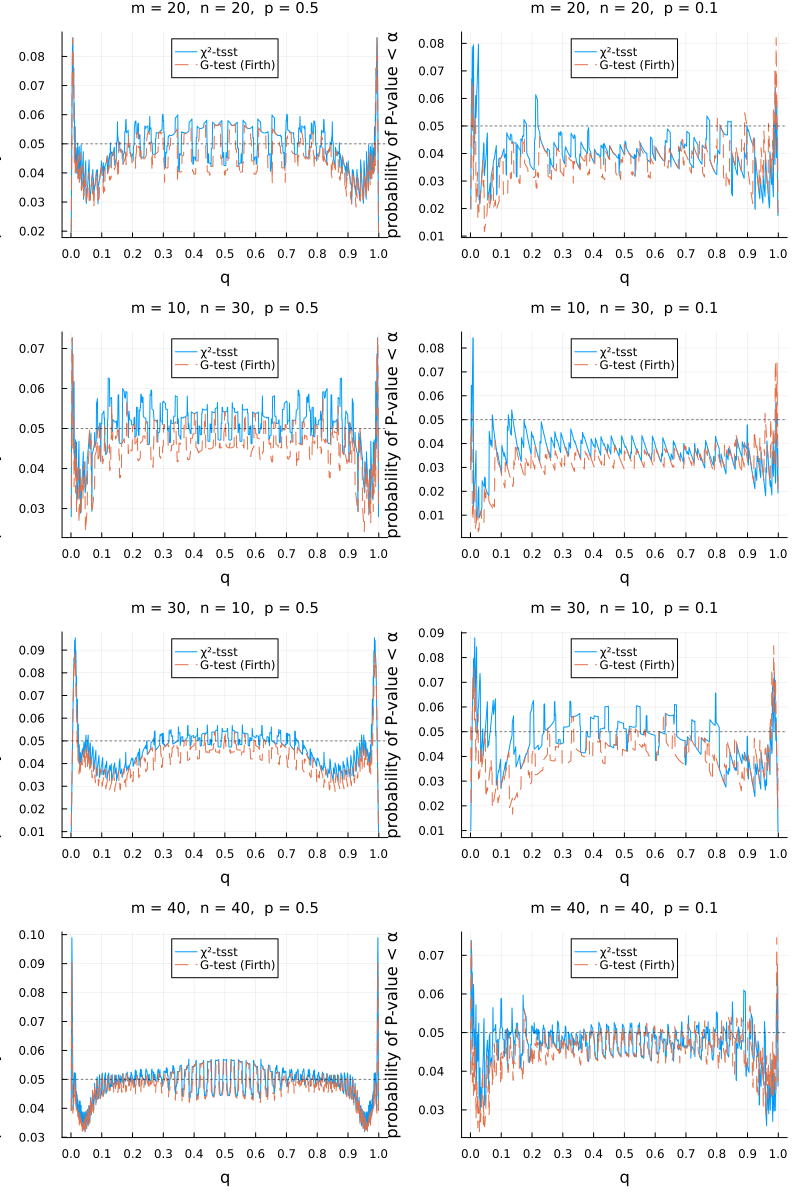

In [9]:
PP = []
for (m, n) in ((20, 20), (10, 30), (30, 10), (40, 40))
    for p in (0.5, 0.1)
        P = plot_alphaerrors_p(; m, n, p)
        push!(PP, P)
    end
end
plot(PP...; size=(800, 1200), layout=(4, 2))

In [10]:
function plot_alphaerrors_or(; m=20, n=20, OR=1.0, α=0.05, legend=:top, f=Bool[1,1,0,0,0])
    p(q) = (v = q/(1-q); u = OR*v; u/(1+u))
    qs = range(0.001, 0.999, 999)
    plot()
    f[1] && plot!(qs, q -> alphaerror_chisq(m, n, p(q), q; α); label="χ²-tsst", c=1)
    f[2] && plot!(qs, q -> alphaerror_gtest_firth(m, n, p(q), q; α); label="G-test (Firth)", ls=:dash, c=2)
    f[3] && plot!(qs, q -> alphaerror_chisq_firth(m, n, p(q), q; α); label="χ²-test (Firth)", ls=:dot, c=3)
    f[4] && plot!(qs, q -> alphaerror_gtest(m, n, p(q), q; α); label="G-test", ls=:dashdot, c=4)
    f[5] && plot!(qs, q -> alphaerror_chisq_yates(m, n, p(q), q; α); label="χ²-test (Yates)", ls=:dashdotdot, c=5)
    hline!([0.05]; label="", ls=:dot, c=:black, alpha=0.5)
    plot!(xtick=0:0.1:1, ytick=0:0.01:1)
    plot!(xguide="q", yguide="probability of P-value < α")
    plot!(legend=:bottom)
    title!("m = $m,  n = $n,  OR = $OR")
end

plot_alphaerrors_or (generic function with 1 method)

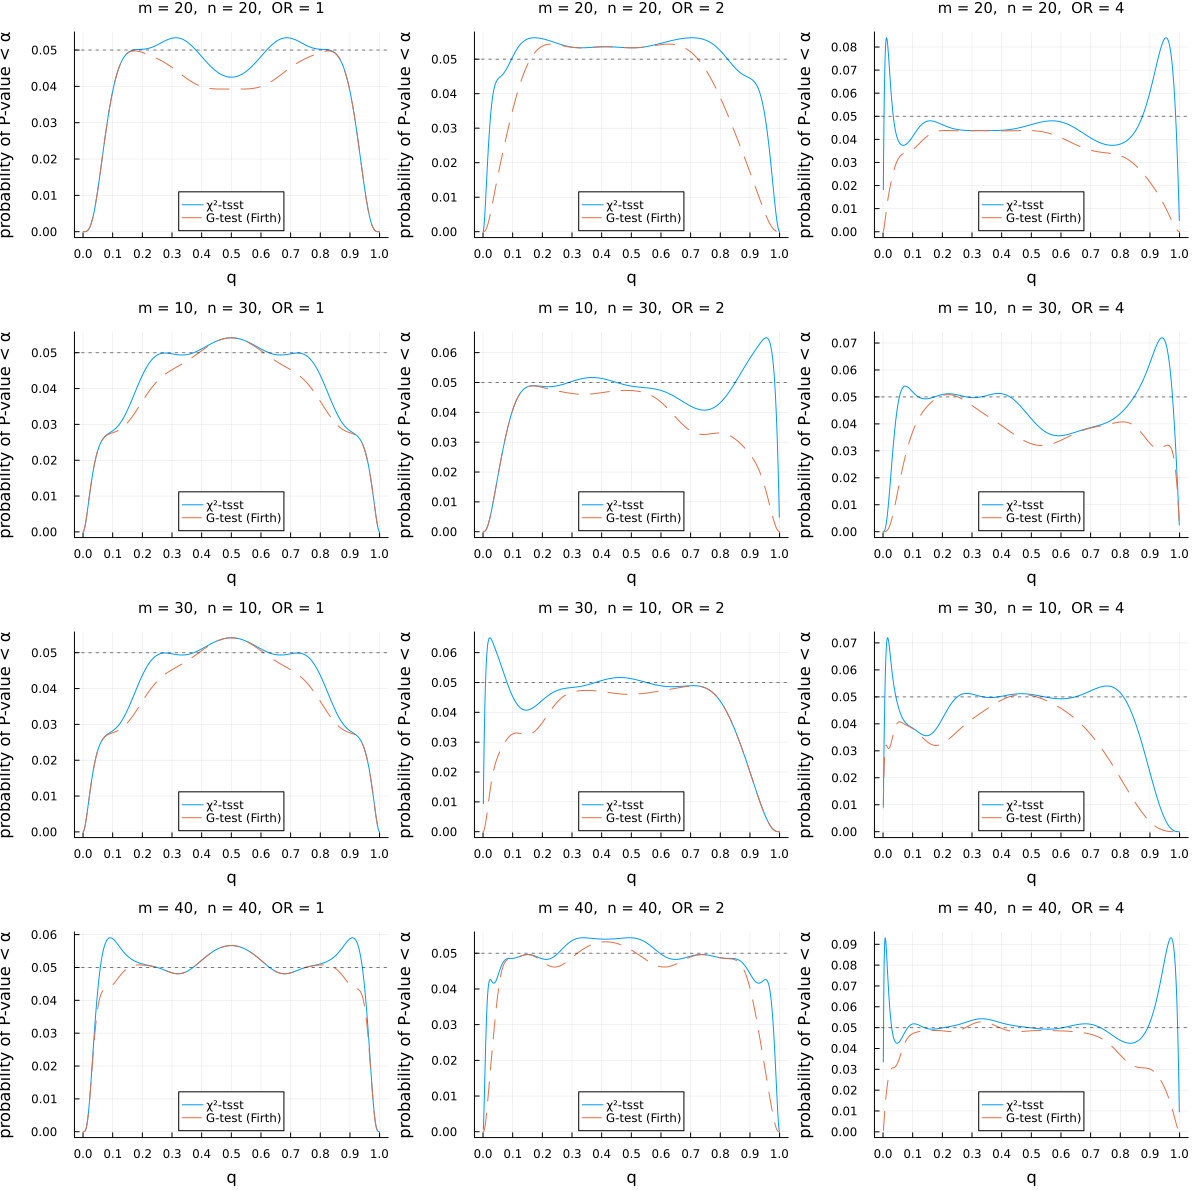

In [11]:
PP = []
for (m, n) in ((20, 20), (10, 30), (30, 10), (40, 40))
    for OR in (1, 2, 4)
        P = plot_alphaerrors_or(; m, n, OR, f=Bool[1,1,0,0,0])
        push!(PP, P)
    end
end
plot(PP...; size=(1200, 1200), layout=(4, 3))